# Process Normalized Cross-Study Dataset

For differential expression analysis, we processed all of the data together on a high memory node.  This was done using the minfi package in R, and all data were normalized using the preprocessQuantile function.  For a full script of the R pipeline see the [Methylation_Normalization_MINFI](./Methylation_Normalization_MINFI.ipynb) notebook.

Imports and helper functions from [Imports](Imports.ipynb) notebook.

In [1]:
cd ..

/cellar/users/agross/TCGA_Code/Methlation


In [3]:
import NotebookImport
from Setup.Imports import *

###Read in Data Normalized Together  
* I had a few issues getting the dataset out of R, so I had to export the data and the sample labels seperately.  
* Here I combine these two files together

In [4]:
ann = pd.read_csv(path + 'data/beta_combined_quantile_labels.csv',
                  index_col=0)
idx = ann.set_index(['studyIndex','sampleNames']).index

df = pd.read_csv(path + 'data/beta_combined_quantile.csv', index_col=0,
                 low_memory=True, engine='c')
df.columns = idx
betas = df

In [5]:
fix_col = lambda s: s if s[0] != 's3' else (s[0], '_'.join(s[1].split('_')[1:]))
betas.columns = pd.MultiIndex.from_tuples(betas.columns.map(fix_col))

####Read in HIV methylation data annotations 

In [6]:
c1 = pd.read_excel(ucsd_path + 'DESIGN_Fox_v2_Samples-ChipLAyout-Clinical UNMC-UCSD methylomestudy.xlsx', 
                   'HIV- samples from OldStudy', index_col=0)
c2 = pd.read_excel(ucsd_path + 'DESIGN_Fox_v2_Samples-ChipLAyout-Clinical UNMC-UCSD methylomestudy.xlsx', 
                   'HIV+ samples', index_col=0)
clinical = c1.append(c2)

Update clinical data with new data provided by Howard Fox

In [7]:
age_new = pd.read_csv(ucsd_path + 'UpdatesAges-Infection.csv', index_col=0)
age = age_new.age.combine_first(clinical.age)
age.name= 'age'
clinical['age'] = age
l = 'estimated duration hiv (months)'
clinical[l] = age_new['Estimated Duration HIV+ (months)'].combine_first(clinical[l])

In [8]:
duration = clinical['estimated duration hiv (months)']
duration = (1.*duration.notnull()) + (1.*duration > 100)
duration = duration.map({0:'HIV Control',1:'HIV Short',2:'HIV Long'})

In [9]:
hiv_age = age
hiv_clinical = clinical
hiv_gender = hiv_clinical.gender.replace(1,'M').combine_first(hiv_clinical.sex)

In [10]:
duration.value_counts()

HIV Long       105
HIV Control     50
HIV Short       37
dtype: int64

### EPIC Italy Cohort

* Prospective cohort study on assesing cancer risk  
* Also record age at menarche, published epigenetic markers associated with this 
* This data was collected post Hannum/Horvath, we want to use this as a control for our models 
* As we are only looking at men in our study we can just look at men here

In [11]:
f = path_italy + 'GSE51032_series_matrix.txt'
ann = pd.read_table(f, skiprows=range(32), low_memory=False, nrows=33, header=0)
ann.iloc[:,0] = ann.iloc[:,0].map(lambda s: s.split('!Sample_')[1])
ann = ann.set_index('!Sample_title')
age_italy = ann.iloc[9].map(lambda s: s.split(': ')[1]).astype(float)
age_italy.name = 'Age'
gender_italy = ann.iloc[8].map(lambda s: s.split(': ')[1])
gender_italy.name = 'Gender'

### Hannum Cohort

* [Genome-wide methylation profiles reveal quantitative views of human aging rates.](http://www.ncbi.nlm.nih.gov/pubmed/23177740) 
* All relatively normal samples (from Glaucoma GWAS?)  
* Half are female, about 1/3 are Hispanic 

In [12]:
f = '/cellar/users/agross/Data/Hannum_Methylation/idats/Full Illumina List Nov 9.txt'
clin = pd.read_table(f, index_col=0)
clin.index = clin.index.map(str)
gender_hannum = clin.sex
age_hannum = clin.Age
ethnicity_hannum = clin.ethnicity
hannum_clinical = pd.concat([age_hannum, gender_hannum, ethnicity_hannum], axis=1,
                            keys=['age', 'gender', 'ethnicity'])

In [13]:
pd.crosstab(hannum_clinical.gender, hannum_clinical.ethnicity).T

gender,F,M
ethnicity,,
Asian - Chinese,1,0
Asian - Filipino,1,0
Asian - Japanese,0,1
Asian - Taiwanese,0,1
Asian - Unknown,1,0
Asian - Vietnamese,1,1
Caribbean,1,0
Caucasian - European,319,288
Caucasian - Middle Eastern,0,1


# Combine Clinical Data

In [14]:
age = pd.concat([hiv_clinical.age, age_hannum, age_italy])
age.name = 'age'

gender = pd.concat([hiv_gender, gender_hannum, gender_italy])
gender.name = 'gender'

In [16]:
study = {}
for i in betas.columns:
    if i[0] == 's2':
        study[i[1]] = duration.ix[i[1]]
    else:
        study[i[1]] = i[0]
study = pd.Series(study)

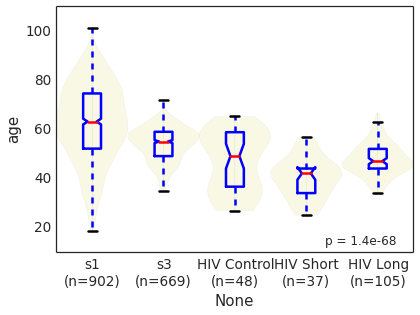

In [17]:
#Do not import
o = ['s1','s3','HIV Control','HIV Short', 'HIV Long']
violin_plot_pandas(study, age, order=o)

In [18]:
hiv = study.isin(['HIV Short','HIV Long'])

### Comparing to Cell-Type Specific Markers

In [19]:
cell_counts = pd.read_csv(path + 'data/beta_combined_cell_counts.csv', index_col=0, 
                      low_memory=False)
ann = pd.read_csv(path + 'data/beta_combined_quantile_labels1.csv',
                  index_col=0)
cell_counts.index = cell_counts.index.map(lambda s: ann.sampleNames.ix[s])
fix_col = lambda s: s if s.startswith('GSM') ==False else '_'.join(s.split('_')[1:])
cell_counts.index = cell_counts.index.map(fix_col)
cell_counts = cell_counts.div(cell_counts.sum(1), axis=0)

In [20]:
screen_feature(study, kruskal_pandas, cell_counts.T, align=False)

,H,p,q
CD8T,247.99,1.77e-52,1.06e-51
CD4T,181.48,3.58e-38,1.08e-37
Mono,60.02,2.88e-12,5.76e-12
Bcell,54.52,4.09e-11,6.14e-11
Gran,14.31,6.38e-03,7.65e-03
NK,11.62,2.04e-02,2.04e-02


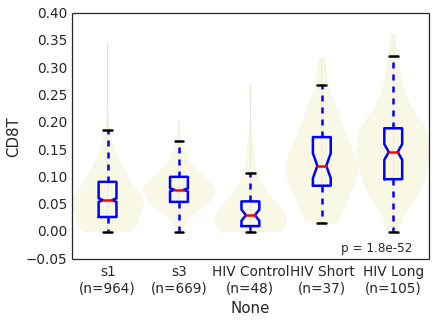

In [21]:
#Do not import
violin_plot_pandas(study, cell_counts.CD8T, order=o)

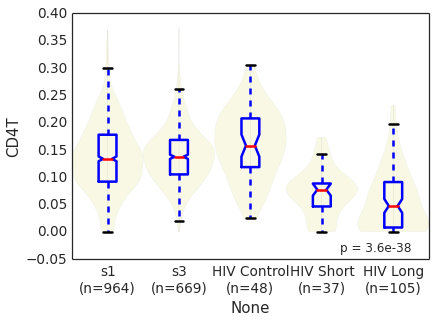

In [22]:
#Do not import
violin_plot_pandas(study, cell_counts.CD4T, order=o)

Looks like some outliers in one of the controls... would be best to drop them.

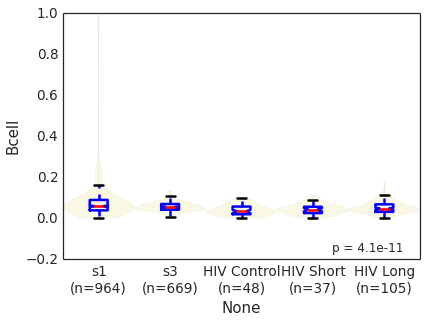

In [23]:
#Do not import
violin_plot_pandas(study, cell_counts.Bcell, order=o)

In [24]:
study = study.ix[ti(cell_counts.Bcell < .25)].dropna()
keepers = study.index

In [26]:
betas = betas.astype(float)

In [27]:
store = pd.HDFStore('/data_ssd/dx_methylation.h5')

In [28]:
store.append('betas', betas)
store.create_table_index('betas', optlevel=9, kind='full')

In [30]:
store['age'] = age
store['study'] = study
store['gender'] = gender

In [31]:
store.append('cell_counts', cell_counts)
store.create_table_index('cell_counts', optlevel=9, kind='full')

In [32]:
store.close()